In [1]:
import os, sys, pickle
import numpy as np
from tqdm import tqdm_notebook as tqdm
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path = list(set(sys.path))
import matplotlib.pyplot as plt
%matplotlib inline

from results_path import DDPG_PATH, PPO_PATH

from common.evaluate import make_vis_env, test_env

from flow.multiagent_envs import MultiWaveAttenuationMergePOEnv
from flow.scenarios import MergeScenario
from flow.utils.registry import make_create_env
from flow.utils.rllib import FlowParamsEncoder
from flow.core.params import InFlows
from ray.tune import run_experiments

import gym, ray
from ray.rllib.agents.ppo import PPOAgent, DEFAULT_CONFIG
from ray.rllib.agents.ddpg import DDPGAgent, DEFAULT_CONFIG
from ray.tune.registry import register_env
from ray.tune.logger import pretty_print

benchmark_name = 'multi_merge'
exp_name = 'random_env'
results_list = os.listdir('/headless/ray_results/' + exp_name)
AGENT = 'HUMAN' # 'PPO' or 'DDPG' or 'HUMAN'
checkpoint = '200'

benchmark = __import__(
    "flow.benchmarks.%s" % benchmark_name, fromlist=["flow_params"])
flow_params = benchmark.buffered_obs_flow_params

ray.init(num_cpus=1, include_webui=False, ignore_reinit_error=True)

Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-04-29_09-00-35_15585/logs.
Waiting for redis server at 127.0.0.1:48177 to respond...
Waiting for redis server at 127.0.0.1:30533 to respond...
Starting the Plasma object store with 20.0 GB memory using /dev/shm.


{'node_ip_address': '10.138.0.2',
 'object_store_addresses': ['/tmp/ray/session_2019-04-29_09-00-35_15585/sockets/plasma_store'],
 'raylet_socket_names': ['/tmp/ray/session_2019-04-29_09-00-35_15585/sockets/raylet'],
 'redis_address': '10.138.0.2:48177',
 'webui_url': ''}

In [2]:
# inflow = InFlows()
# inflow.add(
#     veh_type="human",
#     edge="inflow_highway",
#     vehs_per_hour=2035,
#     #probability=FLOW_PROB,
#     departLane="free",
#     departSpeed=10)
# inflow.add(
#     veh_type="rl",
#     edge="inflow_highway",
#     vehs_per_hour=113,
#     #probability=FLOW_PROB_MERGE,
#     departLane="free",
#     departSpeed=10)
# inflow.add(
#     veh_type="human",
#     edge="inflow_merge",
#     vehs_per_hour=0.175,
#     #probability=FLOW_PROB_RL,
#     departLane="free",
#     departSpeed=7.5)
# 
# # generate new flow_params
# net = flow_params['net']
# net.inflows = inflow
horizon = flow_params['env'].horizon
create_env, env_name = make_create_env(params=flow_params, version=0)

# Register as rllib env
register_env(env_name, create_env)

In [3]:
PPO_PATH = 'PPO_MultiWaveAttenuationMergePOEnvBufferedObs-v0_[eta1, eta2, eta3]:[1.0, 0.1, 0.1]_t_min:10.0_0_2019-04-29_06-30-44frj6v1dt'

In [4]:
PATH = ''
if AGENT == 'PPO':
    PATH = exp_name + '/' + PPO_PATH
    
if AGENT == 'DDPG':
    PATH = exp_name + '/' + DDPG_PATH

In [5]:
if not AGENT == 'HUMAN':
    config_path = '/headless/rl_project/ray_results/' + PATH + '/params.pkl'
    checkpoint_path = '/headless/rl_project/ray_results/' + PATH + '/checkpoint_{}/checkpoint-{}'.format(checkpoint, checkpoint)

    with open(config_path, mode='rb') as f:
        config = pickle.load(f)

    if AGENT == 'PPO':
        agent = PPOAgent(config=config, env=env_name)
    elif AGENT == 'DDPG':
        agent = DDPGAgent(config=config, env=env_name)
    agent.restore(checkpoint_path)

Created LogSyncer for /headless/ray_results/PPO_MultiWaveAttenuationMergePOEnvBufferedObs-v0_2019-04-29_08-48-40m0ekc2dx -> None
2019-04-29 08:48:40,064	WARNING ppo.py:137 -- By default, observations will be normalized with MeanStdFilter
 Starting SUMO on port 44581
2019-04-29 08:48:41,155	INFO policy_evaluator.py:262 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
/opt/conda/envs/flow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
 Starting SUMO on port 44581
2019-04-29 08:48:46,327	INFO multi_gpu_optimizer.py:74 -- LocalMultiGPUOptimizer devices ['/cpu:0']
/opt/conda/envs/flow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. Th

In [3]:
render = False
env = None
if render:
    env = make_vis_env(flow_params, MultiWaveAttenuationMergePOEnv, MergeScenario)
else: 
    env = create_env()

 Starting SUMO on port 43855


In [4]:
# calculate the space-time velocity map
left_length = env.k.scenario.edge_length('left')
car_length = 5.0
scale = 10
vel_lists = []
vel_map_lists = []
outflow_lists = []

num_iter = 1 if render else 6
for _ in tqdm(range(num_iter)):
    state = env.reset()
    vel = []
    outflow = []
    for i in tqdm(range(env.env_params.horizon)):
        # record the mean velocity
        v = np.mean(env.k.vehicle.get_speed(env.k.vehicle.get_ids()))
        vel.append(v)

        # record the velocity map
        ids = env.k.vehicle.get_ids()
        vel_map_ = np.zeros(int(left_length)*scale)
        for id_ in ids:
            pos_ = np.round(env.k.vehicle.get_position(id_), decimals=1)
            vel_ = env.k.vehicle.get_speed(id_)
            pos_bottom = max(0, int((pos_-car_length/2.0)*scale))
            pos_top = min(int(left_length)*scale, int((pos_+car_length/2.0)*scale))
            vel_map_[pos_bottom:pos_top] = vel_            

        # step the simulation
        rl_ids = env.k.vehicle.get_rl_ids()
        actions = {}
        if AGENT != 'HUMAN':
            for id_ in rl_ids:
                action = agent.compute_action(state[id_])
                actions.update({id_: action})
        state, r, _, _ = env.step(actions)
        outflow.append(env.k.vehicle.get_outflow_rate(600)) # measured by one min

        if i == 0:
            vel_map_list = vel_map_
        else:
            vel_map_list = np.vstack((vel_map_list, vel_map_))

    outflow_lists.append(outflow[-500:])
    vel_lists.append(vel)
    vel_map_list[vel_map_list==0.0] = np.nan
    vel_map_lists.append(vel_map_list)

 Starting SUMO on port 43855
 Starting SUMO on port 43855
 Starting SUMO on port 43855
 Starting SUMO on port 43855
 Starting SUMO on port 43855
 Starting SUMO on port 43855


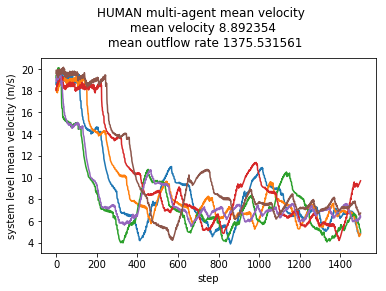

In [5]:
vel_fig, ax = plt.subplots(nrows=1, ncols=1)
for i in range(num_iter):
    ax.plot(vel_lists[i])
title = AGENT + ' multi-agent mean velocity'
title = title + ' \n mean velocity {:3f}'.format(np.mean(vel_lists))
title = title + ' \n mean outflow rate {:3f}'.format(np.mean(outflow_lists))
ax.set_ylabel('system level mean velocity (m/s)')
ax.set_xlabel('step')
vel_fig.suptitle(title)
plt.subplots_adjust(top=0.8)

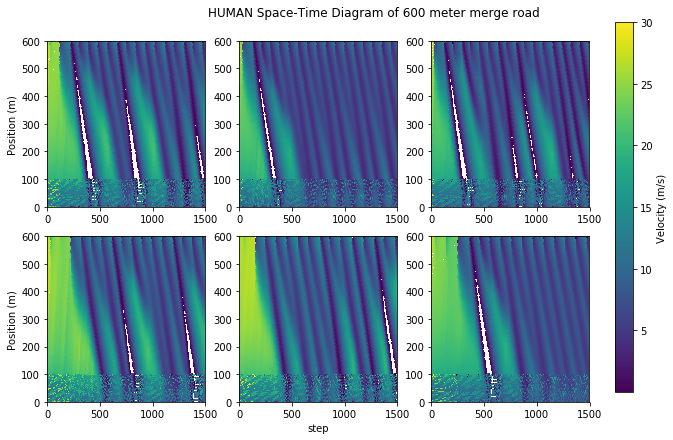

In [6]:
nrows = 1 if render else 2
ncols = 1 if render else 3
space_fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 6))
space_fig.tight_layout()

for i in range(num_iter):
    # plt.subplot(2, 3, i+1)
    x = np.arange(int(env.env_params.horizon))
    y = np.arange(0, int(left_length), step=0.1)
    xx, yy = np.meshgrid(x, y)
    try:
        im = axes[i%2, i%3].pcolormesh(xx, yy, vel_map_lists[i].T)
        if i % 3 == 0:
            axes[i%2, i%3].set_ylabel('Position (m)')
        if int(i / 3.0) > 0:
            axes[int(i/3), int(i/3)].set_xlabel('step')
    except:
        im = axes.pcolormesh(xx, yy, vel_map_lists[i].T)
        if i % 3 == 0:
            axes.set_ylabel('Position (m)')
        if int(i / 3.0) > 0:
            axes.set_xlabel('step')
        
try:
    clb = space_fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.95)
except:
    clb = space_fig.colorbar(im, ax=axes, shrink=0.95)
    
clb.set_clim(0, 30)
clb.set_label('Velocity (m/s)')
title = AGENT + ' Space-Time Diagram of 600 meter merge road'
space_fig.suptitle(title)   
plt.subplots_adjust(top=0.9, right=0.8)

In [11]:
if not render:
    filename = PATH[PATH.find('/') + 1:].replace(' ', '_') + '.png'
    if AGENT == 'HUMAN':
        vel_dir = '../result/MultiMerge/' + AGENT + '/mean_velocity/'
        space_dir = '../result/MultiMerge/' + AGENT + '/space_time_diagram/'
    else:
        vel_dir = '../result/MultiMerge/' + AGENT + '/' + exp_name + '/mean_velocity/'
        space_dir = '../result/MultiMerge/' + AGENT + '/' + exp_name + '/space_time_diagram/'
    os.makedirs(vel_dir, exist_ok=True)
    os.makedirs(space_dir, exist_ok=True)

    vel_fig.savefig(vel_dir + filename)
    space_fig.savefig(space_dir + filename)